In [1]:
import sys
import torch

print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

/home/jovyan/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.6.9 (default, Jun 29 2022, 11:45:57) 
[GCC 8.4.0], sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0) 
Pytorch version: 1.10.0+cu113 


In [2]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple

In [3]:
w = "../weights/yolov7-tiny-nms.trt"
device = torch.device("cuda:0")

In [4]:
# Infer TensorRT Engine
Binding = namedtuple("Binding", ("name", "dtype", "shape", "data", "ptr"))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, "rb") as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()


def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)


def postprocess(boxes, r, dwdh):
    dwdh = torch.tensor(dwdh * 2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes


names = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]
colors = {
    name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)
}

In [5]:
img = cv2.imread("../inference/images/horses.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im.shape

(1, 3, 640, 640)

In [6]:
im = torch.from_numpy(im).to(device)
im /= 255
im.shape

# warmup for 10 times
for _ in range(10):
    tmp = torch.randn(1, 3, 640, 640).to(device)
    binding_addrs["images"] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

start = time.perf_counter()
binding_addrs["images"] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f"Cost {time.perf_counter()-start} s")

nums = bindings["num_dets"].data
boxes = bindings["det_boxes"].data
scores = bindings["det_scores"].data
classes = bindings["det_classes"].data
nums.shape, boxes.shape, scores.shape, classes.shape

Cost 0.006257165223360062 s


(torch.Size([1, 1]),
 torch.Size([1, 100, 4]),
 torch.Size([1, 100]),
 torch.Size([1, 100]))

In [7]:
boxes

tensor([[[362.0000, 284.0000, 493.5000, 395.5000],
         [ -0.7500, 264.5000, 262.0000, 448.5000],
         [215.6250, 270.5000, 351.0000, 411.0000],
         [ -1.0000, 261.2500, 129.2500, 334.2500],
         [306.0000, 280.7500, 378.5000, 372.2500],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  

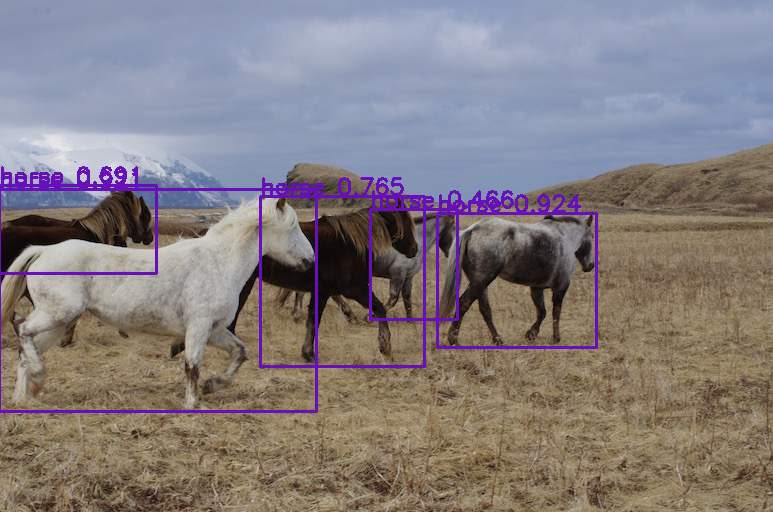

In [8]:
boxes = boxes[0, : nums[0][0]]
scores = scores[0, : nums[0][0]]
classes = classes[0, : nums[0][0]]

for box, score, cl in zip(boxes, scores, classes):
    box = postprocess(box, ratio, dwdh).round().int()
    name = names[cl.round().int()]
    color = colors[name]
    name += " " + str(round(float(score), 3))
    cv2.rectangle(img, box[:2].tolist(), box[2:].tolist(), color, 2)
    cv2.putText(
        img,
        name,
        (int(box[0]), int(box[1]) - 2),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.75,
        color,
        thickness=2,
    )

Image.fromarray(img)